## Text Generation for Emotion Dataset Enrichment

### Why We Used Text Generation Instead of Oversampling/Undersampling/SMOTE

In this project, we chose **text generation** over traditional data balancing techniques such as oversampling, undersampling, and SMOTE for the following reasons:

- **Text data is sequential and contextual**, and duplicating samples (oversampling) can cause overfitting without adding any new linguistic diversity.
- **Undersampling** removes data from majority classes, which leads to a significant loss of valuable information.
- **SMOTE** and similar synthetic methods work well for numerical/tabular data but fail to generate semantically meaningful text.
- Instead, we **trained a Seq2Seq model** to generate high-quality synthetic text samples for underrepresented emotion classes, preserving linguistic structure and emotional context.
- This method helps balance the dataset while improving the model’s ability to generalize across all emotion categories.


## Import the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

## Load the data

In [3]:
df_train=pd.read_csv('/content/train.txt',names=["text","emotions"],sep=';')
df_test=pd.read_csv('/content/test.txt',names=["text","emotions"],sep=';')
df_val=pd.read_csv("/content/val.txt",names=["text","emotions"],sep=';')

In [4]:
display(df_train.sample(2))
display(df_train.sample(2))
display(df_train.sample(2))

,text,emotions
11575,i feel melancholy about the past as my parents...,sadness
8107,i also feels at times that i am somewhat socia...,sadness


,text,emotions
1460,i have the emotions but have learned that to f...,fear
705,i feel like i was a rude ass hole at hookah,anger


,text,emotions
14853,i watched her tears fell i really feel so hear...,sadness
8717,i feel like if i m too fake with lighting you ...,sadness


In [5]:
print(f"The shape of train data is {df_train.shape}")
print(f"The shape of test data is {df_test.shape}")
print(f"The shape of val data is {df_val.shape}")

The shape of train data is (16000, 2)
The shape of test data is (2000, 2)
The shape of val data is (2000, 2)


## Exploratory Data Analysis

In [6]:
def class_count(df):
  emotions=df["emotions"].value_counts()
  print(emotions)

  plt.figure(figsize=(10,5))
  sns.barplot(x=emotions.index,y=emotions.values,palette="rocket")
  plt.title("Emotions Count")
  plt.show()


emotions
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


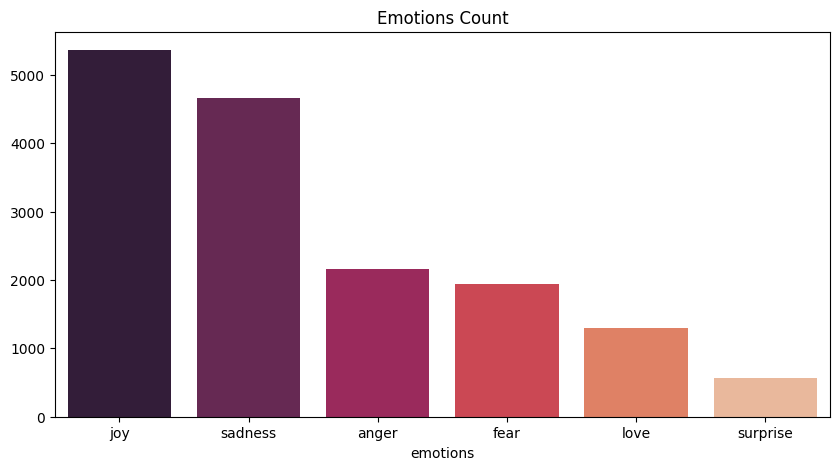

In [7]:
class_count(df_train)

emotions
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


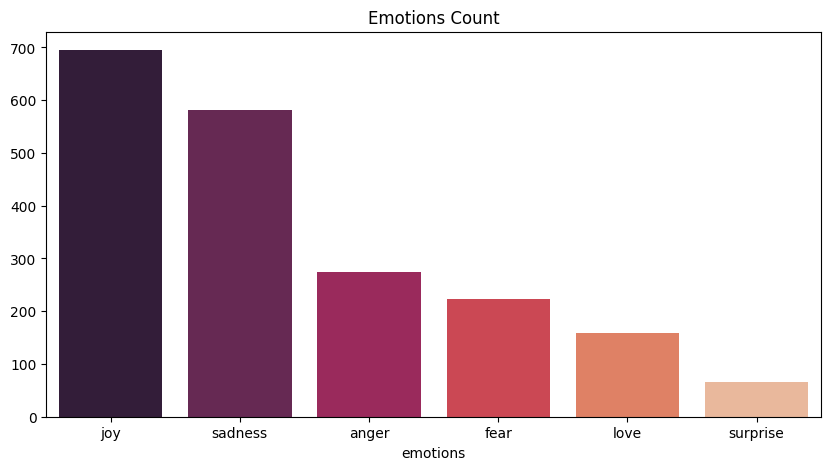

In [8]:
class_count(df_test)

emotions
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64


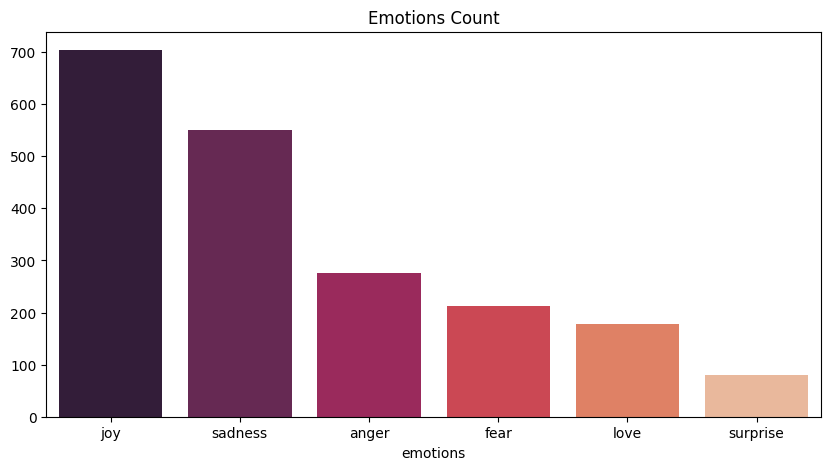

In [9]:
class_count(df_val)

In [10]:
text_count = 0
for text in df_train['text']:
    if len(text.split())<60:
        text_count += 1
print(text_count/len(df_train['text']))

0.998875


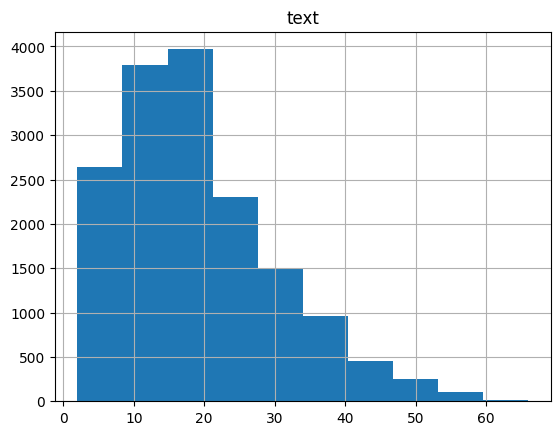

In [11]:
text_word_count = []

# get number of words in text and summary

for i in df_train['text']:
    text_word_count.append(len(i.split()))

length = pd.DataFrame()
length['text'] = pd.Series(text_word_count)

length.hist()
plt.show()

In [12]:
max_sentence_length=60
output_length=20 #generated sentence length

## Combine training, validation, and test sets for text generation
We merge all splits into a single DataFrame to collect all available labeled emotion texts. This allows us to analyze class distributions and preprocess the data more easily, rather than handling each dataset separately.

In [13]:
df = pd.concat([df_train, df_val, df_test], ignore_index=True)
display(df.head())
print(df.shape)

,text,emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


(20000, 2)


In [14]:
df['emotions'].value_counts()

,count
emotions,
joy,6761
sadness,5797
anger,2709
fear,2373
love,1641
surprise,719


To address class imbalance, we first dropped all samples from the majority class `joy` since we will use it as the reference count.

In [15]:
# Drop all 'joy' class samples since we don't need to generate them
df = df[df['emotions'] != 'joy']
df.shape

(13239, 2)

Now, we calculated the number of synthetic samples needed for each of the remaining emotion classes so they can match the `joy` class count (6761 samples). This ensures a balanced dataset for training our sentiment classification model.

In [16]:
# Target count based on 'joy' class
target_count = 6761

# Calculate how many samples to generate per emotion
samples_to_generate = {}

class_counts = df['emotions'].value_counts()
for emotion, count in class_counts.items():
    samples_to_generate[emotion] = target_count - count

# Shows how many synthetic samples are needed for each emotion
print(samples_to_generate)

{'sadness': 964, 'anger': 4052, 'fear': 4388, 'love': 5120, 'surprise': 6042}


## Preprocessing

In [17]:
import re
def clean_text(text):
    text = text.lower()                                 # Lowercase
    text = re.sub(r"http\S+", "", text)                 # Remove URLs
    text = re.sub(r"@\w+", "", text)                    # Remove @mentions
    text = re.sub(r"[^a-z\s]", "", text)                # Remove punctuation/numbers, keep only letters and spaces
    text = re.sub(r"\b(?:ref|http|www|com|turd)\b", "", text)  # Remove unwanted specific words
    text = re.sub(r"\s+", " ", text).strip()            # Normalize whitespace
    return text

In [18]:
df['text'] = df['text'].apply(clean_text)

In [19]:
df.head()

,text,emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


- We are adding the `<sos>` token and the `<eos>` token at the start and end of each sentence to guide the model in conditioned text generation.

- The `<sos>` and `<eos>` tokens define the start and end of the sequence. This structure improves the control and coherence of the generated output

In [20]:
def add_special_tokens(df, text_col='text'):
    # Prepend emotion token and <sos> and append <eos>
    df['Text'] = df.apply(lambda row: f"<sos> {row[text_col]} <eos>", axis=1)
    df.drop('text',inplace=True,axis=1)
    return df

In [21]:
# Apply to our datasets
df = add_special_tokens(df)

In [22]:
df.head()

,emotions,Text
0,sadness,<sos> i didnt feel humiliated <eos>
1,sadness,<sos> i can go from feeling so hopeless to so ...
2,anger,<sos> im grabbing a minute to post i feel gree...
3,love,<sos> i am ever feeling nostalgic about the fi...
4,anger,<sos> i am feeling grouchy <eos>


We have sucessfully added the tokens.

Splitting the dataset into separate DataFrames for each emotion class.Now we can use each of these DataFrames separately for class-wise training or analysis.

In [23]:
sadness_df = df[df['emotions'] == 'sadness']
anger_df = df[df['emotions'] == 'anger']
love_df = df[df['emotions'] == 'love']
fear_df = df[df['emotions'] == 'fear']
surprise_df = df[df['emotions'] == 'surprise']

In [24]:
surprise_df.head()

,emotions,Text
6,surprise,<sos> ive been taking or milligrams or times r...
32,surprise,<sos> i have seen heard and read over the past...
57,surprise,<sos> i keep feeling pleasantly surprised at h...
64,surprise,<sos> i am now nearly finished the week detox ...
129,surprise,<sos> i too feel as if i am a stranger in a st...


We build a separate Seq2Seq model for each emotion and generate the required number of texts. The reason for doing this separately for each emotion is to ensure that the generated texts closely follow the patterns of the training sentences.

## **1.Emotion-Specific Text Generation: *Sadness Class***

### Tokenize: text_to_word_sequence

- A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.

- Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

In [25]:
# let's create tokenizer for sadness_df

sadness_tokenizer = Tokenizer(oov_token="<unk>",filters='')
sadness_tokenizer.fit_on_texts(sadness_df['Text'])
sadness_sequences = sadness_tokenizer.texts_to_sequences(sadness_df['Text'])


- We tokenized the data — i.e., converted the text to numerical values. This allows the neural network to perform operations on the input data.

- When we run the tokenizer, it creates a word index, which is then used to convert each sentence to a vector.


### Padding

In [26]:
# create pad_sequence for sadness_df

sadness_padded = pad_sequences(sadness_sequences, maxlen=max_sentence_length, padding='post', truncating='post')


When we feed our sequences of word IDs into the model, each sequence needs to be the same length. To achieve this, padding is added to any sequence that is shorter than the max length (i.e. shorter than the longest sentence).

### Sequence Splitting for Seq2Seq Model

To prepare data for the encoder-decoder model, we split each padded sequence into three parts:
- **Encoder Input**: The original padded sequence including `<sos>` tokens.
- **Decoder Input**: A right-shifted version of the sequence starting with the `<sos>` token.
- **Decoder Output**: A left-shifted version of the sequence ending with the `<eos>` token.

This setup ensures the model learns to predict the next word during training while being conditioned on both the encoder context and previous outputs.


In [27]:
# create sequence splitting for sadness_df

from sklearn.model_selection import train_test_split

# Assuming sadness_padded is already defined as in your provided code
sadness_encoder_input_data = sadness_padded[:, :-1]
sadness_decoder_input_data = sadness_padded[:, 1:]
sadness_decoder_target_data = np.zeros_like(sadness_decoder_input_data)


#Shifting the decoder target data one step to the left.
sadness_decoder_target_data[:, :-1] = sadness_decoder_input_data[:, 1:]
sadness_decoder_target_data[:, -1] = sadness_tokenizer.word_index['<eos>']


### Train-Validation Split

We split the encoder input and decoder output into training and validation sets using an 80-20 ratio.  
This allows us to train the model on one portion of the data and evaluate its performance on unseen data, helping to detect overfitting and improve generalization.


In [28]:
#Split data into training and validation sets.
sadness_encoder_input_train, sadness_encoder_input_val, sadness_decoder_input_train, sadness_decoder_input_val, sadness_decoder_target_train, sadness_decoder_target_val = train_test_split(
    sadness_encoder_input_data,
    sadness_decoder_input_data,
    sadness_decoder_target_data,
    test_size=0.2,  # Adjust as needed
    random_state=42  # For reproducibility
)

## Model Building

We are using a custom attention layer because keras does not officially support attention layers. We will use third-party implementation of custom attention layer taken from https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py , This implements Bahdanau Attention. For encoder-decoder neural networks, the use of attention allows for the creation of a context vector at each timestep, given the decoder’s current hidden state and a subset of the encoder’s hidden states.

we use this custom attention layer for every emotion.

In [29]:

import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


### Define model

**Seq2Seq Architecture:** The model uses a Sequence-to-Sequence (Seq2Seq) architecture with an encoder-decoder structure, suitable for sequence generation tasks.

**Encoder:** The encoder processes the input sentence, converting it into a fixed-length context vector using an LSTM layer.

**Decoder:** The decoder generates the output sequence by predicting the next word based on the encoder’s context vector, using its own LSTM layer.

**Input & Output:** The encoder input is the tokenized sequence, the decoder input is the shifted sequence with <sos> at the start, and the decoder output is the target sequence with <eos> at the end.

**Training:** The model is trained using sparse categorical cross-entropy loss and the Adam optimizer to predict the next word in the sequence.

**Validation:** The model’s performance is validated using a separate validation set to ensure it generalizes well to unseen data.

**Data Flow:** Both encoder and decoder inputs are fed during training, while the decoder output serves as the target for predictions.

In [30]:
vocab_size = len(sadness_tokenizer.word_index) + 1
latent_dim = 256

# Encoder
sadness_encoder_inputs = Input(shape=(max_sentence_length - 1,))
sadness_enc_emb = Embedding(vocab_size, latent_dim)(sadness_encoder_inputs)
sadness_encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
sadness_encoder_out, sadness_state_h, sadness_state_c = sadness_encoder_lstm(sadness_enc_emb)
sadness_encoder_states = [sadness_state_h, sadness_state_c]

# Decoder
sadness_decoder_inputs = Input(shape=(max_sentence_length - 1,))
sadness_dec_emb_layer = Embedding(vocab_size, latent_dim)
sadness_dec_emb = sadness_dec_emb_layer(sadness_decoder_inputs)
sadness_decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
sadness_decoder_outputs,sadness_decoder_h,sadness_decoder_c = sadness_decoder_lstm(sadness_dec_emb, initial_state=sadness_encoder_states)

# Attention Layer
sadness_attn_layer = AttentionLayer()
sadness_attn_out, sadness_attn_states = sadness_attn_layer([sadness_encoder_out, sadness_decoder_outputs])
sadness_decoder_concat_input = Concatenate(axis=-1)([sadness_decoder_outputs, sadness_attn_out])

# Dense layer
sadness_decoder_dense = TimeDistributed(Dense(len(sadness_tokenizer.word_index) + 1, activation='softmax'))
sadness_decoder_outputs = sadness_decoder_dense(sadness_decoder_concat_input)

In [31]:

# Model
sadness_model = Model([sadness_encoder_inputs, sadness_decoder_inputs], sadness_decoder_outputs)
sadness_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Training with Early Stopping
epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
sadness_history = sadness_model.fit(
    [sadness_encoder_input_train, sadness_decoder_input_train],
    sadness_decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([sadness_encoder_input_val, sadness_decoder_input_val], sadness_decoder_target_val),
    callbacks=[es]
)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 237ms/step - accuracy: 0.6273 - loss: 4.0919 - val_accuracy: 0.6955 - val_loss: 2.0316
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - accuracy: 0.6964 - loss: 1.9784 - val_accuracy: 0.7001 - val_loss: 1.9580
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.7072 - loss: 1.8882 - val_accuracy: 0.7126 - val_loss: 1.8771
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.7143 - loss: 1.8167 - val_accuracy: 0.7271 - val_loss: 1.8087
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.7323 - loss: 1.6906 - val_accuracy: 0.7350 - val_loss: 1.7569
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.7398 - loss: 1.6252 - val_accuracy: 0.7426 - val_loss: 1.7087
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.7497 - loss: 1.5411 - val_accuracy: 0.7482 - val_loss: 1.6751
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.7544 - loss: 1.4880 - val_accu

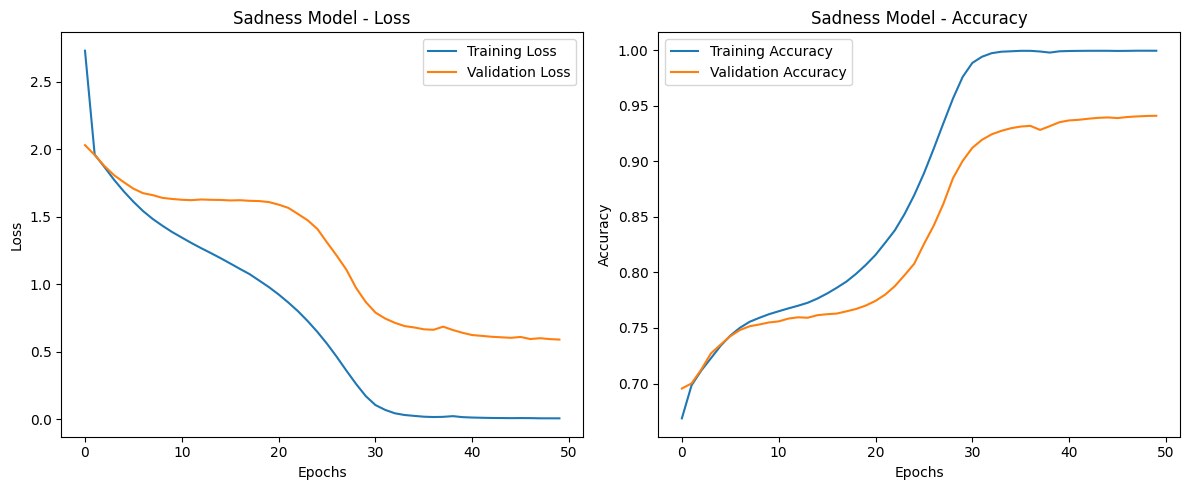

In [33]:
# Extract training history
sadness_loss = sadness_history.history['loss']
sadness_val_loss = sadness_history.history['val_loss']
sadness_accuracy = sadness_history.history['accuracy']
sadness_val_accuracy = sadness_history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(sadness_loss, label='Training Loss')
plt.plot(sadness_val_loss, label='Validation Loss')
plt.title('Sadness Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(sadness_accuracy, label='Training Accuracy')
plt.plot(sadness_val_accuracy, label='Validation Accuracy')
plt.title('Sadness Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Inference

In [34]:
latent_dim = 256  # Define latent dimension

# Encoder inference model
sadness_encoder_model = Model(inputs=sadness_encoder_inputs, outputs=[sadness_encoder_out, sadness_state_h, sadness_state_c])

# Decoder inference model
sadness_decoder_state_input_h = Input(shape=(latent_dim,))
sadness_decoder_state_input_c = Input(shape=(latent_dim,))
sadness_decoder_hidden_state_input = Input(shape=(max_sentence_length - 1, latent_dim))

sadness_dec_emb2 = sadness_dec_emb_layer(sadness_decoder_inputs)

sadness_decoder_outputs2, state_h2, state_c2 = sadness_decoder_lstm(sadness_dec_emb2, initial_state=[sadness_decoder_state_input_h, sadness_decoder_state_input_c])

sadness_attn_out_inf, _ = sadness_attn_layer([sadness_decoder_hidden_state_input, sadness_decoder_outputs2])
sadness_decoder_inf_concat = Concatenate(axis=-1)([sadness_decoder_outputs2, sadness_attn_out_inf])

sadness_decoder_outputs2 = sadness_decoder_dense(sadness_decoder_inf_concat)

sadness_decoder_model = Model(
    [sadness_decoder_inputs, sadness_decoder_hidden_state_input, sadness_decoder_state_input_h, sadness_decoder_state_input_c],
    [sadness_decoder_outputs2, state_h2, state_c2]
)



## Top-p sampling

Instead of using argmax (which always picks the top prediction and can lead to repetitive or less diverse text), we use top-p (nucleus) sampling combined with temperature scaling to introduce randomness and control creativity, resulting in more natural, varied, and contextually rich text generation.

In [36]:
def sample_with_top_p_and_temperature(preds, top_p=0.9, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-10) / temperature  # temperature scaling
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    sorted_indices = np.argsort(preds)[::-1]
    sorted_probs = preds[sorted_indices]
    cumulative_probs = np.cumsum(sorted_probs)

    # Cut off tokens with cumulative probability above top_p
    cutoff_index = np.where(cumulative_probs > top_p)[0][0] + 1
    filtered_indices = sorted_indices[:cutoff_index]
    filtered_probs = sorted_probs[:cutoff_index]
    filtered_probs = filtered_probs / np.sum(filtered_probs)  # Normalize

    sampled_index = np.random.choice(filtered_indices, p=filtered_probs)
    return sampled_index

## Post prepocessing

In [37]:
def post_process_sentence(sentence):
    """
    Adds "I" to the beginning of the sentence if it starts with 'feel' or 'feeling'.
    """
    if sentence.startswith("feel") or sentence.startswith("feeling"):
        sentence = "I am " + sentence if sentence.startswith("feeling") else "I " + sentence
    return sentence

After training the model several times, we observed that despite its high accuracy, it struggled to generate coherent sentence beginnings. To address this, we added post-processing steps to enhance the fluency and meaningfulness of the generated text.

## Grammer correction function

In [38]:
pip install language-tool-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.5 MB/s eta 0:00:00


In [39]:
# Step 1: Remove Java 11
!sudo apt-get remove openjdk-11-* -y

# Step 2: Install Java 17
!sudo apt-get update
!sudo apt-get install openjdk-17-jdk -y

# Step 3: Set Java 17 as the default
!sudo update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-17-openjdk-amd64/bin/java 1
!sudo update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java

# Step 4: Verify the Java version
!java -version


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'openjdk-11-jdk' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-jre' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-jre-headless' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-jdk-headless' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-demo' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-source' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-jre-zero' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-dbg' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-doc' for glob 'openjdk-11-*'
Note, selecting 'openjdk-11-jre-dcevm' for glob 'openjdk-11-*'
Package 'openjdk-11-jre-dcevm' is not installed, so not removed
Package 'openjdk-11-dbg' is not installed, so not removed
Package 'openjdk-11-doc' is not installed, so not removed
Package 'openjdk-11-jdk' is not installed, so not removed
Package 'openjdk-11-jre' is not installed, so not removed
Pack

In [40]:
import language_tool_python

# Initialize LanguageTool for grammar correction
tool = language_tool_python.LanguageTool('en-US')

def correct_grammar(text):
    """Corrects grammar in the input text using LanguageTool."""
    matches = tool.check(text)
    return language_tool_python.utils.correct(text, matches)

INFO:language_tool_python.download_lt:Unzipping /tmp/tmp57qq_yt3.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://internal1.languagetool.org/snapshots/LanguageTool-latest-snapshot.zip to /root/.cache/language_tool_python.


Along with the post-processing steps, we incorporated a grammar correction function using language_tool_python to make the generated sentences more grammatically correct and readable.

## Generating Text Function

In [41]:
max_sentence_length=15
def generate_text_for_sadness(tokenizer, encoder_model, decoder_model, max_len=max_sentence_length-1):
    prompt = "Write a tweet expressing sadness."

    # Convert prompt to sequence
    input_seq_ids = tokenizer.texts_to_sequences([prompt])[0]
    input_seq_padded = pad_sequences([input_seq_ids], maxlen=59, padding='post')

    # Encode prompt
    encoder_out, state_h, state_c = encoder_model.predict(input_seq_padded, verbose=0)
    states = [state_h, state_c]

    # Initialize decoder
    sos_token_index = tokenizer.word_index['<sos>']
    eos_token_index = tokenizer.word_index['<eos>']
    target_seq = np.array([[sos_token_index]])

    decoded_tokens = []

    for _ in range(max_len):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_out, state_h, state_c], verbose=0)
        preds = output_tokens[0, 0, :]
        sampled_token_index = sample_with_top_p_and_temperature(preds, top_p=0.9, temperature=0.7)

        if sampled_token_index == eos_token_index:
            break

        decoded_tokens.append(sampled_token_index)
        target_seq = np.array([[sampled_token_index]])
        state_h, state_c = h, c

    sentence = tokenizer.sequences_to_texts([decoded_tokens])[0]
    sentence = post_process_sentence(sentence)
    sentence = correct_grammar(sentence)

    # Add quality checks
    if not sentence or len(sentence.split()) < 3:
        return generate_text_for_sadness(tokenizer, encoder_model, decoder_model, max_len)

    return sentence

This function generates synthetic tweets that express **sadness** using a trained sequence-to-sequence (seq2seq) model. The generation starts with a predefined prompt (`"Write a tweet expressing sadness."`) and uses an encoder-decoder architecture to generate tokens sequentially.

- It leverages **Top-p (nucleus) sampling** combined with **temperature scaling** to introduce diversity and creativity in the output, avoiding repetitive or overly generic text.
- The decoder starts from a `<sos>` token and generates words until the `<eos>` token is predicted or the maximum sentence length is reached.
- **Post-processing** steps are applied to enhance readability.
- **Grammar correction** is performed using `language_tool_python`.
- **Quality checks** ensure only meaningful outputs (with at least 3 words) are returned.

**Best results** were achieved with:
- **Top-p** = `0.9`
- **Temperature** = `0.7`

This combination strikes a good balance between coherence and variation in generated sentences.

In [42]:
def generate_sadness_texts(n):
    generated = []
    for i in range(n):
        sentence = generate_text_for_sadness(sadness_tokenizer, sadness_encoder_model, sadness_decoder_model, max_len=max_sentence_length - 1)
        generated.append(sentence)
    return generated

In [43]:
sadness_gentext = generate_sadness_texts(10)
sadness_gentext

['I am feeling so a little messy',
 'I am feeling pretty like a hypocrite',
 'I am feeling pretty so homesick',
 'I am feeling so like a bit',
 'I am feeling so like an unsuccessful',
 'I am feeling pretty',
 'I am feeling so like a lifestyle',
 'I am feeling so, so lucky',
 'I am feeling so',
 'I am feeling so, so messy']

Above are 10 synthetic tweets generated by the seq2seq model trained on the *sadness* emotion. The generation uses Top-p sampling with temperature to ensure diversity and emotional relevance.

In [44]:
sadness_gentext = generate_sadness_texts(964)
sadness_gentext

We then generated the required number of synthetic texts to balance the dataset across all emotion classes.

In [45]:

sadness_texts = {'text': sadness_gentext, 'emotions': ['sadness'] * len(sadness_gentext)}

# Convert to DataFrame
df_sadness_texts = pd.DataFrame(sadness_texts)

"sadness_texts = {'text': sadness_gentext, 'emotions': ['sadness'] * len(sadness_gentext)}\n\n# Convert to DataFrame\ndf_sadness_texts = pd.DataFrame(sadness_texts)"

later, we converted them into dataframe and saved as .csv file.

In [47]:
df_sadness_texts.to_csv('sadness_texts.csv', index=False)


In [48]:
# Check if file exists
print("File exists:", os.path.exists('sadness_texts.csv'))

**NOTE:** The same text generation process is applied for each emotion, with slight adjustments to the model and generation parameters (such as prompt, top-p, and temperature). To keep things concise, individual explanations for each emotion are omitted.

## **2.Emotion-Specific Text Generation: *Surprise Class***

In [49]:
surprise_df.head()

,emotions,Text
6,surprise,<sos> ive been taking or milligrams or times r...
32,surprise,<sos> i have seen heard and read over the past...
57,surprise,<sos> i keep feeling pleasantly surprised at h...
64,surprise,<sos> i am now nearly finished the week detox ...
129,surprise,<sos> i too feel as if i am a stranger in a st...


### surprise tokenization

In [50]:
# let's create tokenizer for sadness_df

surprise_tokenizer = Tokenizer(oov_token="<unk>",filters='')
surprise_tokenizer.fit_on_texts(surprise_df['Text'])
surprise_sequences = surprise_tokenizer.texts_to_sequences(surprise_df['Text'])


### surprise padding

In [51]:
# create pad_sequence for sadness_df

surprise_padded = pad_sequences(surprise_sequences, maxlen=60, padding='post', truncating='post')


In [52]:
# create sequence splitting for sadness_df

from sklearn.model_selection import train_test_split

# Assuming sadness_padded is already defined as in your provided code
surprise_encoder_input_data = surprise_padded[:, :-1]
surprise_decoder_input_data = surprise_padded[:, 1:]
surprise_decoder_target_data = np.zeros_like(surprise_decoder_input_data)


#Shifting the decoder target data one step to the left.
surprise_decoder_target_data[:, :-1] = surprise_decoder_input_data[:, 1:]
surprise_decoder_target_data[:, -1] = surprise_tokenizer.word_index['<eos>']


### train_test  split

In [53]:
#Split data into training and validation sets.
surprise_encoder_input_train, surprise_encoder_input_val, surprise_decoder_input_train, surprise_decoder_input_val,surprise_decoder_target_train, surprise_decoder_target_val = train_test_split(
    surprise_encoder_input_data,
    surprise_decoder_input_data,
    surprise_decoder_target_data,
    test_size=0.2,  # Adjust as needed
    random_state=42  # For reproducibility
)

## seq2seq model for surprise emotion

In [136]:
vocab_size = len(surprise_tokenizer.word_index) + 1
latent_dim = 256

# Encoder
surprise_encoder_inputs = Input(shape=(max_sentence_length - 1,))
surprise_enc_emb = Embedding(vocab_size, latent_dim)(surprise_encoder_inputs)
surprise_encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
surprise_encoder_out, surprise_state_h, surprise_state_c = surprise_encoder_lstm(surprise_enc_emb)
surprise_encoder_states = [surprise_state_h, surprise_state_c]

# Decoder
surprise_decoder_inputs = Input(shape=(max_sentence_length - 1,))
surprise_dec_emb_layer = Embedding(vocab_size, latent_dim)
surprise_dec_emb = surprise_dec_emb_layer(surprise_decoder_inputs)
surprise_decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
surprise_decoder_outputs,surpise_decoder_h,surprise_decoder_c = surprise_decoder_lstm(surprise_dec_emb, initial_state=surprise_encoder_states)

# Attention Layer
surprise_attn_layer = AttentionLayer()
surprise_attn_out, surprise_attn_states = surprise_attn_layer([surprise_encoder_out, surprise_decoder_outputs])
surprise_decoder_concat_input = Concatenate(axis=-1)([surprise_decoder_outputs, surprise_attn_out])

# Dense layer
surprise_decoder_dense = TimeDistributed(Dense(len(surprise_tokenizer.word_index) + 1, activation='softmax'))
surprise_decoder_outputs = surprise_decoder_dense(surprise_decoder_concat_input)


In [137]:

# Model
surprise_model = Model([surprise_encoder_inputs, surprise_decoder_inputs], surprise_decoder_outputs)
surprise_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
surprise_model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_43      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, 59, 256)   │    633,344 │ input_layer_42[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (None, 59, 256)   │    633,344 │ input_layer_43[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_24[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_25[0][… │
│                     │ (None, 256),      │            │ lstm_24[0][1],    │
│                     │ (None, 256)]      │            │ lstm_24[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_12  │ [(None, 59, 256), │    131,328 │ lstm_24[0][0],    │
│ (AttentionLayer)    │ (None, 59, 59)]   │            │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 59, 512)   │          0 │ lstm_25[0][0],    │
│ (Concatenate)       │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 59, 2474)  │  1,269,162 │ concatenate_18[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,717,802 (14.18 MB)

 Trainable params: 3,717,802 (14.18 MB)

 Non-trainable params: 0 (0.00 B)

In [138]:
# Training with Early Stopping
epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
surprise_history = surprise_model.fit(
    [surprise_encoder_input_train, surprise_decoder_input_train],
    surprise_decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([surprise_encoder_input_val, surprise_decoder_input_val], surprise_decoder_target_val),
    callbacks=[es]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.4564 - loss: 6.5617 - val_accuracy: 0.6567 - val_loss: 2.5881
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.6454 - loss: 2.5203 - val_accuracy: 0.6503 - val_loss: 2.1907
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6590 - loss: 2.1228 - val_accuracy: 0.6617 - val_loss: 2.1270
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6491 - loss: 2.1364 - val_accuracy: 0.6616 - val_loss: 2.1217
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.6520 - loss: 2.0966 - val_accuracy: 0.6650 - val_loss: 2.1112
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6529 - loss: 2.0963 - val_accuracy: 0.6700 - val_loss: 2.1038
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.6581 - loss: 2.0684 - val_accuracy: 0.6809 - val_loss: 2.1003
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.6771 - loss: 1.9973 - val_accuracy: 0.6808 - val_loss:

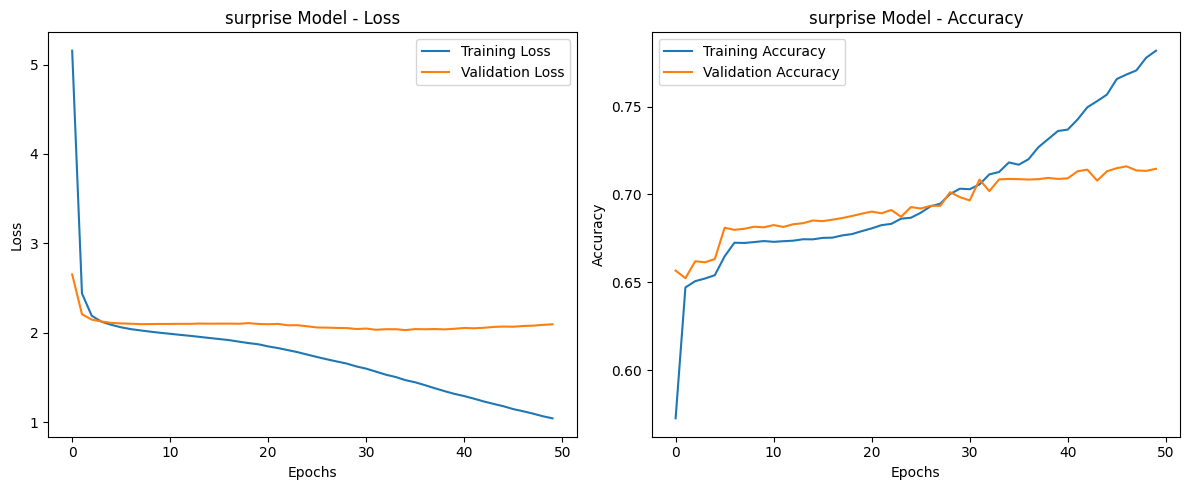

In [129]:
# Extract training history
surprise_loss = surprise_history.history['loss']
surprise_val_loss = surprise_history.history['val_loss']
surprise_accuracy = surprise_history.history['accuracy']
surprise_val_accuracy = surprise_history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(surprise_loss, label='Training Loss')
plt.plot(surprise_val_loss, label='Validation Loss')
plt.title('surprise Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(surprise_accuracy, label='Training Accuracy')
plt.plot(surprise_val_accuracy, label='Validation Accuracy')
plt.title('surprise Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### surprise inference

In [130]:

latent_dim = 256  # Define latent dimension

# Encoder inference model
surprise_encoder_model = Model(inputs=surprise_encoder_inputs, outputs=[surprise_encoder_out, surprise_state_h, surprise_state_c])

# Decoder inference model
surprise_decoder_state_input_h = Input(shape=(latent_dim,))
surprise_decoder_state_input_c = Input(shape=(latent_dim,))
surprise_decoder_hidden_state_input = Input(shape=(max_sentence_length - 1, latent_dim))

surprise_dec_emb2 = surprise_dec_emb_layer(surprise_decoder_inputs)

surprise_decoder_outputs2, state_h2, state_c2 = surprise_decoder_lstm(surprise_dec_emb2, initial_state=[surprise_decoder_state_input_h, surprise_decoder_state_input_c])

surprise_attn_out_inf, _ = surprise_attn_layer([surprise_decoder_hidden_state_input, surprise_decoder_outputs2])
surprise_decoder_inf_concat = Concatenate(axis=-1)([surprise_decoder_outputs2, surprise_attn_out_inf])

surprise_decoder_outputs2 = surprise_decoder_dense(surprise_decoder_inf_concat)

surprise_decoder_model = Model(
    [surprise_decoder_inputs, surprise_decoder_hidden_state_input, surprise_decoder_state_input_h, surprise_decoder_state_input_c],
    [surprise_decoder_outputs2, state_h2, state_c2]
)



In [131]:
def is_sentence_valid(sentence):
    if sentence.count(" a ") > 2 or (sentence.count("of a") > 1):
        return False
    if len(sentence.split()) < 3 or len(sentence.split()) > max_sentence_length:
        return False
    if sentence.lower().startswith("on feeling like") or sentence.lower().startswith("on a feeling") or sentence.lower().startswith("on a") or sentence.lower().startswith("on"):
        return False
    return True


## generate text for surprise

In [132]:

max_sentence_length=60
# Generator function for one surprise sentence
def generate_text_for_surprise(tokenizer, encoder_model, decoder_model, max_len=max_sentence_length-1):
    prompt = "Generate a tweet expressing surprise"

    input_seq_ids = tokenizer.texts_to_sequences([prompt])[0]
    input_seq_padded = pad_sequences([input_seq_ids], maxlen=max_len, padding='post')

    encoder_out, state_h, state_c = encoder_model.predict(input_seq_padded, verbose=0)
    states = [state_h, state_c]

    sos_token_index = tokenizer.word_index['<sos>']
    eos_token_index = tokenizer.word_index['<eos>']
    target_seq = np.array([[sos_token_index]])

    decoded_tokens = []

    for _ in range(15):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_out, state_h, state_c], verbose=0
        )
        preds = output_tokens[0, 0, :]
        sampled_token_index = sample_with_top_p_and_temperature(preds, top_p=0.9, temperature=0.5)

        if sampled_token_index == eos_token_index:
            break

        decoded_tokens.append(sampled_token_index)
        target_seq = np.array([[sampled_token_index]])
        state_h, state_c = h, c

    sentence = tokenizer.sequences_to_texts([decoded_tokens])[0]
    sentence = post_process_sentence(sentence)
    sentence = correct_grammar(sentence)

    if not is_sentence_valid(sentence):
        return generate_text_for_surprise(tokenizer, encoder_model, decoder_model, max_len)

    return sentence

In [133]:
def generate_surprise_texts(n):
    generated = []
    for i in range(n):
        sentence = generate_text_for_surprise(surprise_tokenizer, surprise_encoder_model, surprise_decoder_model, max_len=max_sentence_length - 1)
        generated.append(sentence)
    return generated

In [134]:
surprise_gentext = generate_surprise_texts(10)
surprise_gentext

['I am feeling curious',
 'I am feeling a little strange',
 'I feel so funny',
 'I am feeling absolutely overwhelmed',
 'I feel so overwhelmed',
 'I am feeling strange brew',
 'I am feeling absolutely amazing',
 'I am feeling so dazed',
 'I feel so a bit dazed',
 'I am feeling funny']

Above are 10 synthetic tweets generated by the seq2seq model trained on the *surprise* emotion. The generation uses Top-p sampling with temperature to ensure diversity and emotional relevance.

In [64]:
surprise_gentext = generate_surprise_texts(6042) #we need 6042 texts to balance the data.
surprise_gentext

'surprise_gentext = generate_surprise_texts(6042)\nsurprise_gentext'

In [65]:

surprise_texts = {'text': surprise_gentext, 'emotions': ['surprise'] * len(surprise_gentext)}

# Convert to DataFrame
df_surprise_texts = pd.DataFrame(surprise_texts)

"surprise_texts = {'text': surprise_gentext, 'emotions': ['surprise'] * len(surprise_gentext)}\n\n# Convert to DataFrame\ndf_surprise_texts = pd.DataFrame(surprise_texts)"

In [67]:
df_surprise_texts.to_csv('/kaggle/working/surprise_texts.csv', index=False)


## **3.Emotion-Specific Text Generation: *Love Class***

In [69]:
love_df

,emotions,Text
3,love,<sos> i am ever feeling nostalgic about the fi...
9,love,<sos> i feel romantic too <eos>
47,love,<sos> i can t let go of that sad feeling that ...
61,love,<sos> i ate i could feel a gentle tingle throu...
68,love,<sos> i suppose my own truth needs to be share...
...,...,...
19961,love,<sos> i remember wanting to fit in so bad and ...
19969,love,<sos> i can feel the warmth of the gentle sun ...
19970,love,<sos> i guess as long as the table in the abov...
19990,love,<sos> i really feel like they were gentle remi...


### Tokenization for love emotion

In [70]:
# let's create tokenizer for love_df

love_tokenizer = Tokenizer(oov_token="<unk>",filters='')
love_tokenizer.fit_on_texts(love_df['Text'])
love_sequences = love_tokenizer.texts_to_sequences(love_df['Text'])

In [71]:
# create pad_sequence for love_df

love_padded = pad_sequences(love_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

### encoder decoder inputs

In [72]:
# create sequence splitting for love_df

from sklearn.model_selection import train_test_split

# Assuming love_padded is already defined as in your provided code
love_encoder_input_data = love_padded[:, :-1]
love_decoder_input_data = love_padded[:, 1:]
love_decoder_target_data = np.zeros_like(love_decoder_input_data)


#Shifting the decoder target data one step to the left.
love_decoder_target_data[:, :-1] =love_decoder_input_data[:, 1:]
love_decoder_target_data[:, -1] = love_tokenizer.word_index['<eos>']

### Train test split


In [73]:
#Split data into training and validation sets.
love_encoder_input_train, love_encoder_input_val, love_decoder_input_train, love_decoder_input_val, love_decoder_target_train, love_decoder_target_val = train_test_split(
    love_encoder_input_data,
    love_decoder_input_data,
    love_decoder_target_data,
    test_size=0.2,  # Adjust as needed
    random_state=42  # For reproducibility
)

### model building for love emotion

In [139]:
vocab_size = len(love_tokenizer.word_index) + 1
latent_dim = 256

# Encoder
love_encoder_inputs = Input(shape=(max_sentence_length - 1,))
love_enc_emb = Embedding(vocab_size, latent_dim)(love_encoder_inputs)
love_encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
love_encoder_out, love_state_h, love_state_c = love_encoder_lstm(love_enc_emb)
love_encoder_states = [love_state_h, love_state_c]

# Decoder
love_decoder_inputs = Input(shape=(max_sentence_length - 1,))
love_dec_emb_layer = Embedding(vocab_size, latent_dim)
love_dec_emb = love_dec_emb_layer(love_decoder_inputs)
love_decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
love_decoder_outputs,love_decoder_h,love_decoder_c = love_decoder_lstm(love_dec_emb, initial_state=love_encoder_states)

# Attention Layer
love_attn_layer = AttentionLayer()
love_attn_out, love_attn_states = love_attn_layer([love_encoder_out, love_decoder_outputs])
love_decoder_concat_input = Concatenate(axis=-1)([love_decoder_outputs, love_attn_out])

# Dense layer
love_decoder_dense = TimeDistributed(Dense(len(love_tokenizer.word_index) + 1, activation='softmax'))
love_decoder_outputs = love_decoder_dense(love_decoder_concat_input)

In [140]:

# Model
love_model = Model([love_encoder_inputs, love_decoder_inputs], love_decoder_outputs)
love_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
love_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_45      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, 59, 256)   │  1,130,752 │ input_layer_44[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, 59, 256)   │  1,130,752 │ input_layer_45[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_26[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_27[0][… │
│                     │ (None, 256),      │            │ lstm_26[0][1],    │
│                     │ (None, 256)]      │            │ lstm_26[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_13  │ [(None, 59, 256), │    131,328 │ lstm_26[0][0],    │
│ (AttentionLayer)    │ (None, 59, 59)]   │            │ lstm_27[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 59, 512)   │          0 │ lstm_27[0][0],    │
│ (Concatenate)       │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 59, 4417)  │  2,265,921 │ concatenate_19[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,709,377 (21.78 MB)

 Trainable params: 5,709,377 (21.78 MB)

 Non-trainable params: 0 (0.00 B)

In [141]:
# Training with Early Stopping
epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
love_history = love_model.fit(
    [love_encoder_input_train, love_decoder_input_train],
    love_decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([love_encoder_input_val, love_decoder_input_val], love_decoder_target_val),
    callbacks=[es]
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - accuracy: 0.5255 - loss: 5.8314 - val_accuracy: 0.6196 - val_loss: 2.4785
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.6304 - loss: 2.3825 - val_accuracy: 0.6455 - val_loss: 2.2682
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.6462 - loss: 2.2295 - val_accuracy: 0.6482 - val_loss: 2.2412
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.6482 - loss: 2.2263 - val_accuracy: 0.6624 - val_loss: 2.2306
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.6626 - loss: 2.1529 - val_accuracy: 0.6636 - val_loss: 2.2235
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.6666 - loss: 2.1002 - val_accuracy: 0.6637 - val_loss: 2.2207
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.6619 - loss: 2.1291 - val_accuracy: 0.6656 - val_loss: 2.2146
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.6545 - loss: 2.1522 - val_accuracy: 0

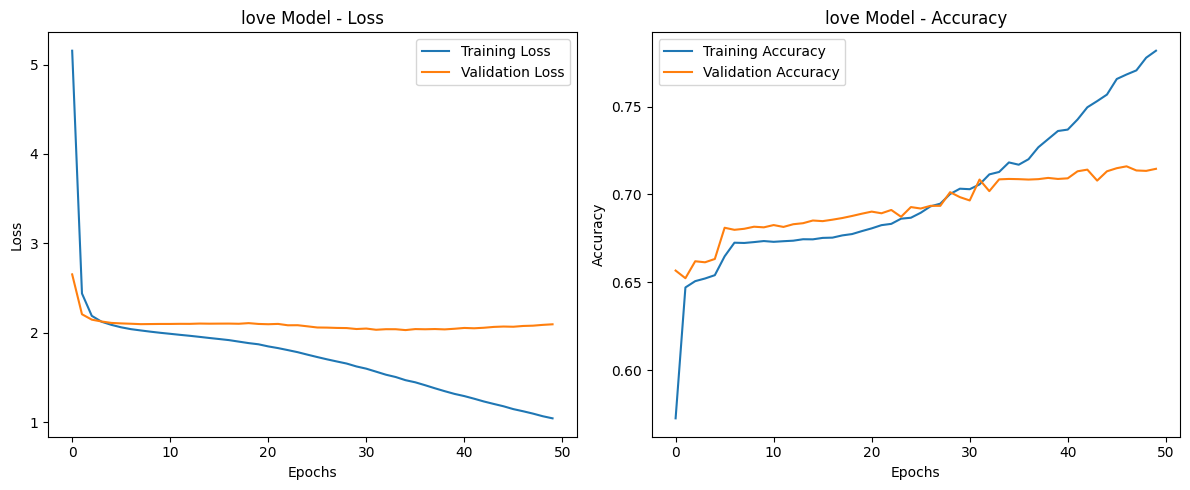

In [142]:
# Extract training history
love_loss = love_history.history['loss']
love_val_loss = love_history.history['val_loss']
love_accuracy = love_history.history['accuracy']
love_val_accuracy = love_history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(surprise_loss, label='Training Loss')
plt.plot(surprise_val_loss, label='Validation Loss')
plt.title('love Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(surprise_accuracy, label='Training Accuracy')
plt.plot(surprise_val_accuracy, label='Validation Accuracy')
plt.title('love Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Inference for love

In [143]:

latent_dim = 256  # Define latent dimension

# Encoder inference model
love_encoder_model = Model(inputs=love_encoder_inputs, outputs=[love_encoder_out, love_state_h, love_state_c])

# Decoder inference model
love_decoder_state_input_h = Input(shape=(latent_dim,))
love_decoder_state_input_c = Input(shape=(latent_dim,))
love_decoder_hidden_state_input = Input(shape=(max_sentence_length - 1, latent_dim))

love_dec_emb2 = love_dec_emb_layer(love_decoder_inputs)

love_decoder_outputs2, state_h2, state_c2 = love_decoder_lstm(love_dec_emb2, initial_state=[love_decoder_state_input_h, love_decoder_state_input_c])

love_attn_out_inf, _ = love_attn_layer([love_decoder_hidden_state_input, love_decoder_outputs2])
love_decoder_inf_concat = Concatenate(axis=-1)([love_decoder_outputs2, love_attn_out_inf])

love_decoder_outputs2 = love_decoder_dense(love_decoder_inf_concat)

love_decoder_model = Model(
    [love_decoder_inputs, love_decoder_hidden_state_input, love_decoder_state_input_h, love_decoder_state_input_c],
    [love_decoder_outputs2, state_h2, state_c2]
)



## generate text fuction for love

In [144]:

def generate_text_for_love(tokenizer, encoder_model, decoder_model, max_len=max_sentence_length-1):
    prompt = "Describe a beautiful moment of love"

    # Convert prompt to sequence
    input_seq_ids = tokenizer.texts_to_sequences([prompt])[0]
    input_seq_padded = pad_sequences([input_seq_ids], maxlen=max_len, padding='post')

    # Encode prompt
    encoder_out, state_h, state_c = encoder_model.predict(input_seq_padded, verbose=0)
    states = [state_h, state_c]

    # Initialize decoder
    sos_token_index = tokenizer.word_index['<sos>']
    eos_token_index = tokenizer.word_index['<eos>']
    target_seq = np.array([[sos_token_index]])

    decoded_tokens = []

    for _ in range(20):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_out, state_h, state_c], verbose=0)
        preds = output_tokens[0, 0, :]
        sampled_token_index = sample_with_top_p_and_temperature(preds, top_p=0.9, temperature=0.7)

        if sampled_token_index == eos_token_index:
            break

        decoded_tokens.append(sampled_token_index)
        target_seq = np.array([[sampled_token_index]])
        state_h, state_c = h, c

    sentence = tokenizer.sequences_to_texts([decoded_tokens])[0]
    sentence = post_process_sentence(sentence)
    sentence = correct_grammar(sentence)

    # Add quality checks
    if not sentence or len(sentence.split()) < 3:
        return generate_text_for_love(tokenizer, encoder_model, decoder_model, max_lenght)

    return sentence


In [145]:
def generate_love_texts(n):
    generated = []
    for i in range(n):
        sentence = generate_text_for_love(love_tokenizer, love_encoder_model, love_decoder_model, max_len=max_sentence_length - 1)
        generated.append(sentence)
    return generated

In [146]:
love_gentext = generate_love_texts(10)
love_gentext

['To feeling accepted and hot',
 'I am feeling the naughty feelings for the story',
 'I am feeling very nostalgic and IMG hand',
 'I am feeling generous when I feel so hot',
 'I am feeling hot and somewhat so hot',
 'To feel very nostalgic to be her',
 'I am feeling the longing to grow of a gentle kid',
 'I am feeling that completely not t share',
 'To feeling nostalgic',
 'To feel horny']

Above are 10 synthetic tweets generated by the seq2seq model trained on the *Love* emotion. The generation uses Top-p sampling with temperature to ensure diversity and emotional relevance.

In [82]:
love_gentext = love_surprise_texts(5120) #we need 5120 texts to balance the data
love_gentext

'love_gentext = love_surprise_texts(5120)\nlove_gentext'

In [83]:
love_texts = {'text': love_gentext, 'emotions': ['love'] * len(love_gentext)}

# Convert to DataFrame
df_love_texts = pd.DataFrame(love_texts)

"love_texts = {'text': love_gentext, 'emotions': ['love'] * len(love_gentext)}\n\n# Convert to DataFrame\ndf_love_texts = pd.DataFrame(love_texts)"

In [85]:
df_love_texts.to_csv('/kaggle/working/love_texts.csv', index=False)

## **4.Emotion-Specific Text Generation: *Fear Class***

In [86]:
fear_df.head()

,emotions,Text
7,fear,<sos> i feel as confused about life as a teena...
19,fear,<sos> i now feel compromised and skeptical of ...
21,fear,<sos> i am feeling completely overwhelmed i ha...
31,fear,<sos> i remember feeling acutely distressed fo...
53,fear,<sos> i was stymied a little bit as i wrote fe...


### Tokenization

In [87]:
# let's create tokenizer for fear_df
fear_tokenizer = Tokenizer(num_words=5000,oov_token="<unk>",filters='')
fear_tokenizer.fit_on_texts(fear_df['Text'])
fear_sequences = fear_tokenizer.texts_to_sequences(fear_df['Text'])

### padding

In [88]:
# create pad_sequence for fear_df

fear_padded = pad_sequences(fear_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

### Encoder decoder inputs

In [89]:
# create sequence splitting for love_df

from sklearn.model_selection import train_test_split

# Assuming love_padded is already defined as in your provided code
fear_encoder_input_data = fear_padded[:, :-1]
fear_decoder_input_data = fear_padded[:, 1:]
fear_decoder_target_data = np.zeros_like(fear_decoder_input_data)


#Shifting the decoder target data one step to the left.
fear_decoder_target_data[:, :-1] =fear_decoder_input_data[:, 1:]
fear_decoder_target_data[:, -1] = fear_tokenizer.word_index['<eos>']

### Train-Test split

In [90]:
#Split data into training and validation sets.
fear_encoder_input_train, fear_encoder_input_val, fear_decoder_input_train, fear_decoder_input_val, fear_decoder_target_train, fear_decoder_target_val = train_test_split(
    fear_encoder_input_data,
    fear_decoder_input_data,
    fear_decoder_target_data,
    test_size=0.2,  # Adjust as needed
    random_state=1  # For reproducibility
)

### Model Buliding

In [147]:
vocab_size = len(fear_tokenizer.word_index) + 1
latent_dim = 256

# Encoder
fear_encoder_inputs = Input(shape=(max_sentence_length - 1,))
fear_enc_emb = Embedding(vocab_size, latent_dim)(fear_encoder_inputs)
fear_encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
fear_encoder_out, fear_state_h, fear_state_c = fear_encoder_lstm(fear_enc_emb)
fear_encoder_states = [fear_state_h, fear_state_c]

# Decoder
fear_decoder_inputs = Input(shape=(max_sentence_length - 1,))
fear_dec_emb_layer = Embedding(vocab_size, latent_dim)
fear_dec_emb = fear_dec_emb_layer(fear_decoder_inputs)
fear_decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
fear_decoder_outputs,fear_decode_h,fear_decoder_c = fear_decoder_lstm(fear_dec_emb, initial_state=fear_encoder_states)

# Attention Layer
fear_attn_layer = AttentionLayer()
fear_attn_out, fear_attn_states = fear_attn_layer([fear_encoder_out, fear_decoder_outputs])
fear_decoder_concat_input = Concatenate(axis=-1)([fear_decoder_outputs, fear_attn_out])

# Dense layer
fear_decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
fear_decoder_outputs = fear_decoder_dense(fear_decoder_concat_input)


In [148]:
# Model
fear_model = Model([fear_encoder_inputs, fear_decoder_inputs], fear_decoder_outputs)
fear_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fear_model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_50      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, 59, 256)   │  1,266,944 │ input_layer_49[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_29        │ (None, 59, 256)   │  1,266,944 │ input_layer_50[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_28[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_29[0][… │
│                     │ (None, 256),      │            │ lstm_28[0][1],    │
│                     │ (None, 256)]      │            │ lstm_28[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_14  │ [(None, 59, 256), │    131,328 │ lstm_28[0][0],    │
│ (AttentionLayer)    │ (None, 59, 59)]   │            │ lstm_29[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 59, 512)   │          0 │ lstm_29[0][0],    │
│ (Concatenate)       │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 59, 4949)  │  2,538,837 │ concatenate_21[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,254,677 (23.86 MB)

 Trainable params: 6,254,677 (23.86 MB)

 Non-trainable params: 0 (0.00 B)

In [150]:
# Training with Early Stopping
epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
fear_history = fear_model.fit(
    [fear_encoder_input_train, fear_decoder_input_train],
    fear_decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([fear_encoder_input_val, fear_decoder_input_val], fear_decoder_target_val),
    callbacks=[es]
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.8247 - loss: 0.8380 - val_accuracy: 0.7394 - val_loss: 1.9091
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.8303 - loss: 0.8048 - val_accuracy: 0.7395 - val_loss: 1.9111
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.8377 - loss: 0.7662 - val_accuracy: 0.7377 - val_loss: 1.9287
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.8400 - loss: 0.7477 - val_accuracy: 0.7392 - val_loss: 1.9405
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.8491 - loss: 0.7030 - val_accuracy: 0.7391 - val_loss: 1.9461
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.8532 - loss: 0.6784 - val_accuracy: 0.7386 - val_loss: 1.9562
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.8534 - loss: 0.6775 - val_accuracy: 0.7401 - val_loss: 1.9558
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.8642 - loss: 0.6332 - val_accur

In [92]:
# Model
fear_model = Model([fear_encoder_inputs, fear_decoder_inputs], fear_decoder_outputs)
fear_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fear_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 59, 256)   │  1,266,944 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 59, 256)   │  1,266,944 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 59, 256), │    525,312 │ embedding_8[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 59, 256), │    525,312 │ embedding_9[0][0… │
│                     │ (None, 256),      │            │ lstm_8[0][1],     │
│                     │ (None, 256)]      │            │ lstm_8[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_4   │ [(None, 59, 256), │    131,328 │ lstm_8[0][0],     │
│ (AttentionLayer)    │ (None, 59, 59)]   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 59, 512)   │          0 │ lstm_9[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 59, 4949)  │  2,538,837 │ concatenate_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,254,677 (23.86 MB)

 Trainable params: 6,254,677 (23.86 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Training with Early Stopping
epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=5, restore_best_weights=True)
fear_history = fear_model.fit(
    [fear_encoder_input_train, fear_decoder_input_train],
    fear_decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([fear_encoder_input_val, fear_decoder_input_val], fear_decoder_target_val),
    callbacks=[es]
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.5853 - loss: 5.0959 - val_accuracy: 0.6556 - val_loss: 2.2071
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.6656 - loss: 2.0957 - val_accuracy: 0.6689 - val_loss: 2.1277
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.6853 - loss: 2.0135 - val_accuracy: 0.6798 - val_loss: 2.1058
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.6971 - loss: 1.9155 - val_accuracy: 0.6807 - val_loss: 2.0829
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.6920 - loss: 1.9275 - val_accuracy: 0.6830 - val_loss: 2.0479
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.6992 - loss: 1.8591 - val_accuracy: 0.6870 - val_loss: 2.0131
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


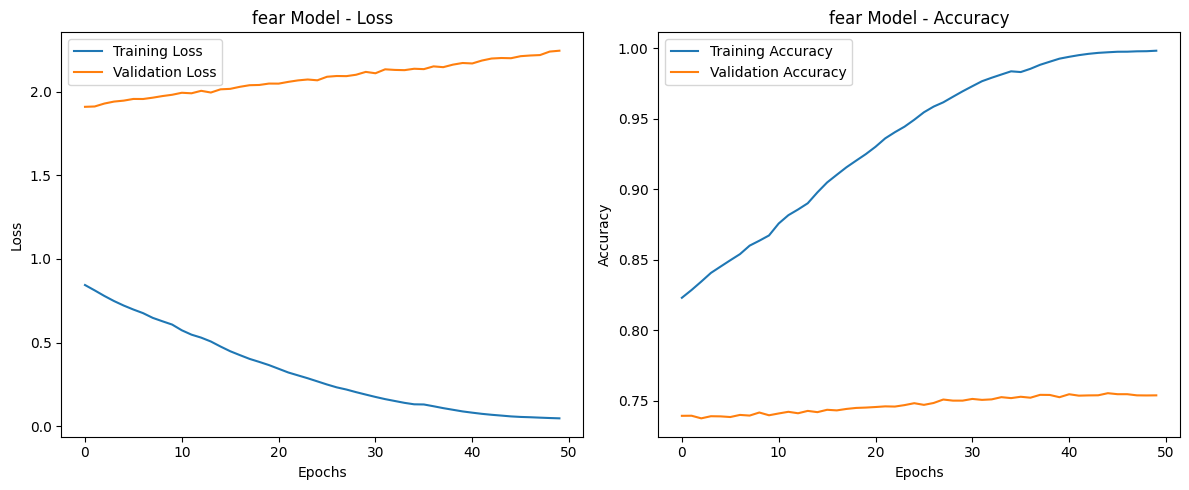

In [151]:
# Extract training history
fear_loss = fear_history.history['loss']
fear_val_loss = fear_history.history['val_loss']
fear_accuracy = fear_history.history['accuracy']
fear_val_accuracy = fear_history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(fear_loss, label='Training Loss')
plt.plot(fear_val_loss, label='Validation Loss')
plt.title('fear Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(fear_accuracy, label='Training Accuracy')
plt.plot(fear_val_accuracy, label='Validation Accuracy')
plt.title('fear Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Inference

In [152]:

latent_dim = 256

# Encoder inference model
fear_encoder_model = Model(inputs=fear_encoder_inputs, outputs=[fear_encoder_out, fear_state_h, fear_state_c])

# Decoder inference model
fear_decoder_state_input_h = Input(shape=(latent_dim,))
fear_decoder_state_input_c = Input(shape=(latent_dim,))
fear_decoder_hidden_state_input = Input(shape=(max_sentence_length - 1, latent_dim))

fear_dec_emb2 = fear_dec_emb_layer(fear_decoder_inputs)

fear_decoder_outputs2, state_h2, state_c2 = fear_decoder_lstm(fear_dec_emb2, initial_state=[fear_decoder_state_input_h, fear_decoder_state_input_c])

fear_attn_out_inf, _ = fear_attn_layer([fear_decoder_hidden_state_input,fear_decoder_outputs2])
fear_decoder_inf_concat = Concatenate(axis=-1)([fear_decoder_outputs2, fear_attn_out_inf])

fear_decoder_outputs2 = fear_decoder_dense(fear_decoder_inf_concat)

fear_decoder_model = Model(
    [fear_decoder_inputs, fear_decoder_hidden_state_input, fear_decoder_state_input_h, fear_decoder_state_input_c],
    [fear_decoder_outputs2, state_h2, state_c2]
)



### Generate text function for fear

In [153]:

def generate_text_for_fear(tokenizer, encoder_model, decoder_model, max_len=max_sentence_length-1):
    prompt = "Generate a tweet expressing fear"

    # Convert prompt to sequence
    input_seq_ids = tokenizer.texts_to_sequences([prompt])[0]
    input_seq_padded = pad_sequences([input_seq_ids], maxlen=max_len, padding='post')

    # Encode prompt
    encoder_out, state_h, state_c = encoder_model.predict(input_seq_padded, verbose=0)
    states = [state_h, state_c]

    # Initialize decoder
    sos_token_index = tokenizer.word_index['<sos>']
    eos_token_index = tokenizer.word_index['<eos>']
    target_seq = np.array([[sos_token_index]])

    decoded_tokens = []

    for _ in range(15):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_out, state_h, state_c], verbose=0)
        preds = output_tokens[0, 0, :]
        sampled_token_index = sample_with_top_p_and_temperature(preds, top_p=0.9, temperature=0.7)

        if sampled_token_index == eos_token_index:
            break

        decoded_tokens.append(sampled_token_index)
        target_seq = np.array([[sampled_token_index]])
        state_h, state_c = h, c

    sentence = tokenizer.sequences_to_texts([decoded_tokens])[0]
    sentence = post_process_sentence(sentence)
    sentence = correct_grammar(sentence)

    # Add quality checks
    if not sentence or len(sentence.split()) < 3:
        return generate_text_for_fear(tokenizer, encoder_model, decoder_model, max_sentence_length)

    return sentence


In [154]:
def generate_fear_texts(n):
    generated = []
    for i in range(n):
        sentence = generate_text_for_fear(fear_tokenizer, fear_encoder_model, fear_decoder_model, max_len=max_sentence_length - 1)
        generated.append(sentence)
    return generated

In [155]:
fear_gentext = generate_fear_texts(10)
fear_gentext

['A feeling a bit paranoid',
 'A feeling a bit uptight',
 'A feeling so I suffered from nightmares',
 'A feeling a little girl blubbering fool old girl',
 'A feeling a little girl old',
 'A feeling a bit skeptical',
 'A feeling a bit tortured',
 'A feeling so I suffered from trying to make',
 'a feeling a bit shaken',
 'A feeling so a bit nervous']

Above are 10 synthetic tweets generated by the seq2seq model trained on the *fear* emotion. The generation uses Top-p sampling with temperature to ensure diversity and emotional relevance.

In [99]:
fear_gentext = fear_surprise_texts(5120)
fear_gentext

'fear_gentext = fear_surprise_texts(5120)\nfear_gentext'

In [100]:
fear_texts = {'text': fear_gentext, 'emotions': ['fear'] * len(fear_gentext)}

# Convert to DataFrame
df_fear_texts = pd.DataFrame(fear_texts)

"fear_texts = {'text': fear_gentext, 'emotions': ['fear'] * len(fear_gentext)}\n\n# Convert to DataFrame\ndf_fear_texts = pd.DataFrame(fear_texts)"

In [102]:
df_fear_texts.to_csv('/kaggle/working/fear_texts.csv', index=False)

## **5.Emotion-Specific Text Generation: *Anger Class***

In [104]:
anger_df

,emotions,Text
2,anger,<sos> im grabbing a minute to post i feel gree...
4,anger,<sos> i am feeling grouchy <eos>
12,anger,<sos> i think it s the easiest time of year to...
20,anger,<sos> i feel irritated and rejected without an...
24,anger,<sos> i already feel like i fucked up though b...
...,...,...
19984,anger,<sos> i came out of the airport that makes me ...
19992,anger,<sos> i feel tortured delilahlwl am considerin...
19993,anger,<sos> i told my fiance how i am feeling so ang...
19995,anger,<sos> i just keep feeling like someone is bein...


### Tokenization

In [105]:
# let's create tokenizer for anger_df
anger_tokenizer = Tokenizer(oov_token="<unk>",filters='')
anger_tokenizer.fit_on_texts(anger_df['Text'])
anger_sequences = fear_tokenizer.texts_to_sequences(anger_df['Text'])

### padding

In [106]:
# create pad_sequence for anger_df

anger_padded = pad_sequences(anger_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

### Encoder-Decoder inputs

In [107]:
# create sequence splitting for anger_df

from sklearn.model_selection import train_test_split

# Assuming love_padded is already defined as in your provided code
anger_encoder_input_data = anger_padded[:, :-1]
anger_decoder_input_data = anger_padded[:, 1:]
anger_decoder_target_data = np.zeros_like(anger_decoder_input_data)


#Shifting the decoder target data one step to the left.
anger_decoder_target_data[:, :-1] =anger_decoder_input_data[:, 1:]
anger_decoder_target_data[:, -1] = anger_tokenizer.word_index['<eos>']

### Train_Test_Split

In [108]:
#Split data into training and validation sets.
anger_encoder_input_train, anger_encoder_input_val, anger_decoder_input_train, anger_decoder_input_val, anger_decoder_target_train, anger_decoder_target_val = train_test_split(
    anger_encoder_input_data,
    anger_decoder_input_data,
    anger_decoder_target_data,
    test_size=0.2,  # Adjust as needed
    random_state=1  # For reproducibility
)

### model building

In [156]:
vocab_size = len(anger_tokenizer.word_index) + 1
latent_dim = 256

# Encoder
anger_encoder_inputs = Input(shape=(max_sentence_length - 1,))
anger_enc_emb = Embedding(vocab_size, latent_dim)(anger_encoder_inputs)
anger_encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
anger_encoder_out, anger_state_h, anger_state_c = anger_encoder_lstm(anger_enc_emb)
anger_encoder_states = [anger_state_h, anger_state_c]

# Decoder
anger_decoder_inputs = Input(shape=(max_sentence_length - 1,))
anger_dec_emb_layer = Embedding(vocab_size, latent_dim)
anger_dec_emb = anger_dec_emb_layer(anger_decoder_inputs)
anger_decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
anger_decoder_outputs,anger_decoder_h,anger_decoder_c = anger_decoder_lstm(anger_dec_emb, initial_state=anger_encoder_states)

# Attention Layer
anger_attn_layer = AttentionLayer()
anger_attn_out, anger_attn_states = anger_attn_layer([anger_encoder_out, anger_decoder_outputs])
anger_decoder_concat_input = Concatenate(axis=-1)([anger_decoder_outputs, anger_attn_out])

# Dense layer
anger_decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
anger_decoder_outputs = anger_decoder_dense(anger_decoder_concat_input)


In [157]:
# Model
anger_model = Model([anger_encoder_inputs, anger_decoder_inputs], anger_decoder_outputs)
anger_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
anger_model.summary()


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_54      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_55      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_30        │ (None, 59, 256)   │  1,408,768 │ input_layer_54[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_31        │ (None, 59, 256)   │  1,408,768 │ input_layer_55[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_30[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_31[0][… │
│                     │ (None, 256),      │            │ lstm_30[0][1],    │
│                     │ (None, 256)]      │            │ lstm_30[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_15  │ [(None, 59, 256), │    131,328 │ lstm_30[0][0],    │
│ (AttentionLayer)    │ (None, 59, 59)]   │            │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_23      │ (None, 59, 512)   │          0 │ lstm_31[0][0],    │
│ (Concatenate)       │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 59, 5503)  │  2,823,039 │ concatenate_23[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,822,527 (26.03 MB)

 Trainable params: 6,822,527 (26.03 MB)

 Non-trainable params: 0 (0.00 B)

In [158]:
# Training with Early Stopping and increased epochs for higher accuracy
epochs = 50  # Increased epochs
batch_size = 64
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
anger_history = anger_model.fit(
    [anger_encoder_input_train, anger_decoder_input_train],
    anger_decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([anger_encoder_input_val, anger_decoder_input_val], anger_decoder_target_val),
    callbacks=[es]
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.5842 - loss: 4.9834 - val_accuracy: 0.6580 - val_loss: 1.9859
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.6811 - loss: 1.8878 - val_accuracy: 0.6873 - val_loss: 1.8892
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.6949 - loss: 1.8128 - val_accuracy: 0.6899 - val_loss: 1.8572
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6969 - loss: 1.7871 - val_accuracy: 0.6903 - val_loss: 1.8289
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6970 - loss: 1.7626 - val_accuracy: 0.6979 - val_loss: 1.7944
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.7066 - loss: 1.7227 - val_accuracy: 0.7110 - val_loss: 1.7578
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.7148 - loss: 1.6884 - val_accuracy: 0.7077 - val_loss: 1.7280
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.7202 - loss: 1.6308 - val_accurac

In [110]:
# Model
anger_model = Model([anger_encoder_inputs,anger_decoder_inputs], anger_decoder_outputs)
anger_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
anger_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 59)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 59, 256)   │  1,408,768 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 59, 256)   │  1,266,944 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_10[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ [(None, 59, 256), │    525,312 │ embedding_9[2][0… │
│                     │ (None, 256),      │            │ lstm_10[0][1],    │
│                     │ (None, 256)]      │            │ lstm_10[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_5   │ [(None, 59, 256), │    131,328 │ lstm_10[0][0],    │
│ (AttentionLayer)    │ (None, 59, 59)]   │            │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 59, 512)   │          0 │ lstm_11[0][0],    │
│ (Concatenate)       │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 59, 5503)  │  2,823,039 │ concatenate_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,680,703 (25.48 MB)

 Trainable params: 6,680,703 (25.48 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Training with Early Stopping
epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=5, restore_best_weights=True)
anger_history =anger_model.fit(
    [anger_encoder_input_train, anger_decoder_input_train],
    anger_decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([anger_encoder_input_val, anger_decoder_input_val], anger_decoder_target_val),
    callbacks=[es]
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.5824 - loss: 4.7492 - val_accuracy: 0.6648 - val_loss: 1.9587
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.6811 - loss: 1.8918 - val_accuracy: 0.6876 - val_loss: 1.8989
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.6980 - loss: 1.8051 - val_accuracy: 0.6883 - val_loss: 1.9035
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.6926 - loss: 1.8331 - val_accuracy: 0.6898 - val_loss: 1.8489
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.6998 - loss: 1.7480 - val_accuracy: 0.6947 - val_loss: 1.7916
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.7057 - loss: 1.6822 - val_accuracy: 0.7002 - val_loss: 1.7425
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


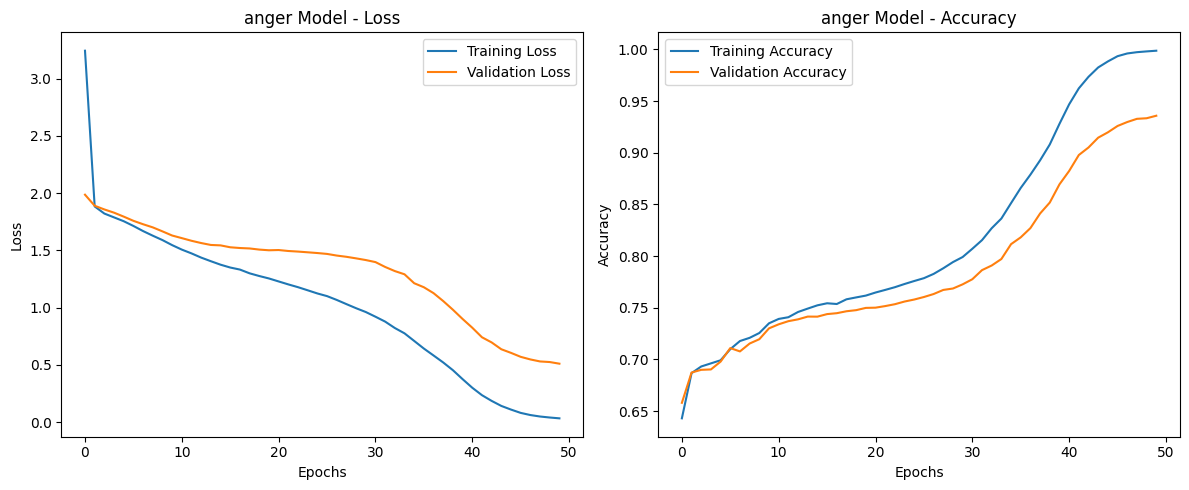

In [159]:
# Extract training history
anger_loss = anger_history.history['loss']
anger_val_loss = anger_history.history['val_loss']
anger_accuracy = anger_history.history['accuracy']
anger_val_accuracy = anger_history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(anger_loss, label='Training Loss')
plt.plot(anger_val_loss, label='Validation Loss')
plt.title('anger Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(anger_accuracy, label='Training Accuracy')
plt.plot(anger_val_accuracy, label='Validation Accuracy')
plt.title('anger Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Inference

In [160]:

latent_dim = 256

# Encoder inference model
anger_encoder_model = Model(inputs=anger_encoder_inputs, outputs=[anger_encoder_out,anger_state_h,anger_state_c])

# Decoder inference model
anger_decoder_state_input_h = Input(shape=(latent_dim,))
anger_decoder_state_input_c = Input(shape=(latent_dim,))
anger_decoder_hidden_state_input = Input(shape=(max_sentence_length - 1, latent_dim))

anger_dec_emb2 = anger_dec_emb_layer(anger_decoder_inputs)

anger_decoder_outputs2, state_h2, state_c2 = anger_decoder_lstm(anger_dec_emb2, initial_state=[anger_decoder_state_input_h, anger_decoder_state_input_c])

anger_attn_out_inf, _ = anger_attn_layer([anger_decoder_hidden_state_input,anger_decoder_outputs2])
anger_decoder_inf_concat = Concatenate(axis=-1)([anger_decoder_outputs2, anger_attn_out_inf])

anger_decoder_outputs2 =anger_decoder_dense(anger_decoder_inf_concat)

anger_decoder_model = Model(
    [anger_decoder_inputs, anger_decoder_hidden_state_input, anger_decoder_state_input_h, anger_decoder_state_input_c],
    [anger_decoder_outputs2, state_h2, state_c2]
)


### Generate text function for anger

In [191]:

def generate_text_for_anger(tokenizer, encoder_model, decoder_model, max_len=max_sentence_length-1):
    prompt = "generate a tweet expressing your anger"

    # Convert prompt to sequence
    input_seq_ids = tokenizer.texts_to_sequences([prompt])[0]
    input_seq_padded = pad_sequences([input_seq_ids], maxlen=max_len, padding='post')

    # Encode prompt
    encoder_out, state_h, state_c = encoder_model.predict(input_seq_padded, verbose=0)
    states = [state_h, state_c]

    # Initialize decoder
    sos_token_index = tokenizer.word_index['<sos>']
    eos_token_index = tokenizer.word_index['<eos>']
    target_seq = np.array([[sos_token_index]])

    decoded_tokens = []

    for _ in range(15):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_out, state_h, state_c], verbose=0)
        preds = output_tokens[0, 0, :]
        sampled_token_index = sample_with_top_p_and_temperature(preds, top_p=0.9, temperature=0.7)

        if sampled_token_index == eos_token_index:
            break

        decoded_tokens.append(sampled_token_index)
        target_seq = np.array([[sampled_token_index]])
        state_h, state_c = h, c

    sentence = tokenizer.sequences_to_texts([decoded_tokens])[0]
    sentence = post_process_sentence(sentence)
    sentence = correct_grammar(sentence)

    # Add quality checks
    if not sentence or len(sentence.split()) < 3:
        return generate_text_for_anger(tokenizer, encoder_model, decoder_model, max_sentence_length)

    return sentence


In [192]:
def generate_anger_texts(n):
    generated = []
    for i in range(n):
        sentence = generate_text_for_anger(anger_tokenizer, anger_encoder_model, anger_decoder_model, max_len=max_sentence_length - 1)
        generated.append(sentence)
    return generated

In [193]:
anger_gentext = generate_anger_texts(10)
anger_gentext

['I am feeling but',
 'I am feeling feelings',
 'I am feeling but',
 'I am feeling <unk> your this said',
 'I am feeling but feelings <unk>',
 'I am feeling but feelings',
 'I am feeling feelings',
 'I am feeling feelings',
 'I am feeling feelings',
 'I am feeling but feelings <unk> your minibus']

Above are 10 synthetic tweets generated by the seq2seq model trained on the *anger* emotion. The generation uses Top-p sampling with temperature to ensure diversity and emotional relevance.

In [165]:
anger_gentext = anger_surprise_texts(5120)
anger_gentext

'anger_gentext = anger_surprise_texts(5120)\nanger_gentext'

In [119]:
df_anger_texts.to_csv('/kaggle/working/anger_texts.csv', index=False)

## conlusion
- This project successfully implemented a text generation model to augment an emotion classification dataset.  
- By training separate sequence-to-sequence (Seq2Seq) models with attention mechanisms for each emotion category (sadness, surprise, love, fear, and anger), the model generated synthetic text samples.  
- The use of top-p sampling and temperature control in the text generation process helped to ensure diversity and quality, while post-processing and grammar correction further enhanced the generated text's coherence and readability.
- The generated synthetic data addressed class imbalance issues in the original dataset, ultimately aiming to improve the performance of a downstream emotion classification model.  
- The project demonstrated a practical approach to data augmentation for imbalanced datasets using deep learning techniques.
